# Translate JHU dataset

https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data/csse_covid_19_time_series

https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv

https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv

https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv

In [35]:
# Plots inline with the code
%matplotlib inline

# Data manipulation and visualization
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Libraries to read data from web downloads and generate a dataframe
import requests
from io import StringIO


In [18]:
# Sets the notebook to use the full width of the window
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

In [19]:
number_countries = 12

## Get the datasets

In [40]:
confirmed_web = requests.get('https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv', allow_redirects=True)
confirmed_io = StringIO(confirmed_web.text)
confirmed_df = pd.read_csv(confirmed_io)
confirmed_df.drop(['Long', 'Lat'], axis=1, inplace=True)



In [42]:

df_list = list()
for c in set(confirmed_df['Country/Region']):
    country = c
    totals = confirmed_df[confirmed_df['Country/Region'] == country].sum()
    daily_new_cases = totals[2:].diff()
    # Place back first row
    daily_new_cases[0] = totals[2]
    df_country = pd.DataFrame(daily_new_cases)
    df_country = df_country.rename(columns={0:'daily_new_cases'})
    df_country['country'] = country
    df_list.append(df_country)


In [43]:
df_all = pd.concat(df_list)
df_all = df_all.reset_index().rename(columns={'index':'date'})
df_all = df_all[df_all['daily_new_cases'] > 0]
df_all['date'] = pd.to_datetime(df_all['date'])
df_all.to_csv('covid19_confirmed_2020_03_19.csv', index=False)

In [44]:
df = df_all
groups =  df.groupby('country')
top10 = list(groups['daily_new_cases'].sum().sort_values(ascending=False).keys()[0:number_countries])
top10_df = df[df['country'].isin(top10)]
df_list = list()
for c in top10:
    first_case = top10_df[top10_df['country'] == c]['date'].min()
    days_since_first_case = top10_df[top10_df['country'] == c]['date'] - first_case
    country_df = pd.DataFrame()
    country_df['days_since_first_case'] = days_since_first_case
    country_df['new_cases'] =  np.int64(top10_df[top10_df['country'] == c]['daily_new_cases'])
    country_df['Country'] = c
    df_list.append(country_df)
    print('{}: {}'.format(c, country_df['new_cases'].sum()))

countries_df = pd.concat(df_list, ignore_index=True)
countries_df['days_since_first_case'] = countries_df['days_since_first_case'].dt.days


China: 81439
Italy: 59138
US: 33276
Spain: 28768
Germany: 24873
Iran: 21638
France: 16176
Korea, South: 8897
Switzerland: 7245
United Kingdom: 5741
Netherlands: 4216
Belgium: 3401


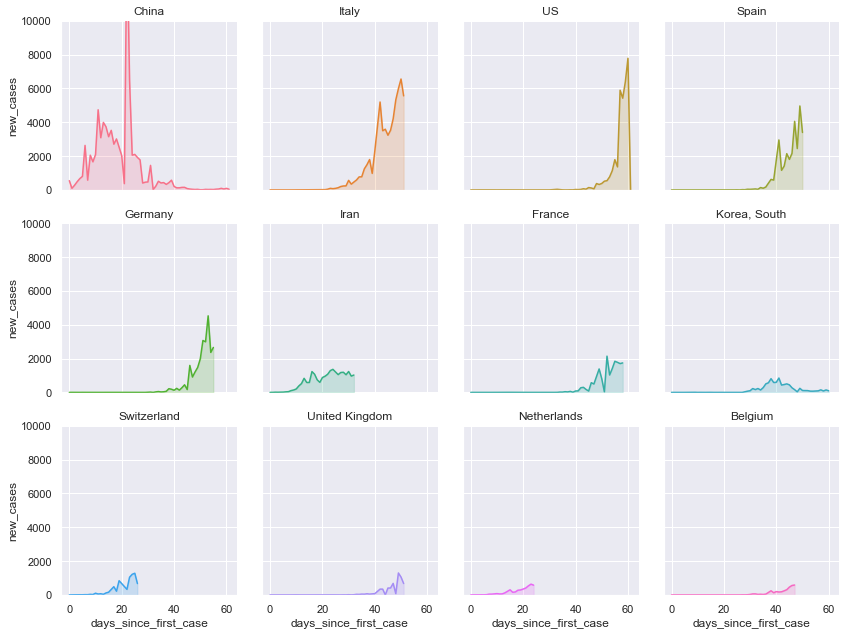

In [45]:
sns.set(style="ticks")
with sns.axes_style("darkgrid"):
    grid = sns.FacetGrid(countries_df, col="Country", hue='Country', col_wrap=4, height=3)
    #grid.map(plt.plot, "days_since_first_case", "new_cases", marker="o", )
    grid.map(plt.plot, "days_since_first_case", "new_cases").set_titles("{col_name}")
    grid.map(plt.fill_between, "days_since_first_case", "new_cases", alpha=0.2).set_titles("{col_name}")

    #grid.fig.tight_layout(w_pad=1)
    grid.set(ylim = [-20,10000])

# Confirmed deaths

In [24]:
df_deaths = pd.read_csv('time_series_19-covid-Deaths.txt')
df_deaths.drop(['Long', 'Lat'], axis=1, inplace=True)
df_list = list()
for c in set(df_deaths['Country/Region']):
    country = c
    totals = df_deaths[df_deaths['Country/Region'] == country].sum()
    daily_new_cases = totals[2:].diff()
    # Place back first row
    daily_new_cases[0] = totals[2]
    df_country = pd.DataFrame(daily_new_cases)
    df_country = df_country.rename(columns={0:'daily_new_cases'})
    df_country['country'] = country
    df_list.append(df_country)
df_all_deaths = pd.concat(df_list)
df_all_deaths = df_all_deaths.reset_index().rename(columns={'index':'date'})
df_all_deaths = df_all_deaths[df_all_deaths['daily_new_cases'] > 0]
df_all_deaths['date'] = pd.to_datetime(df_all_deaths['date'])
#df_all_deaths.to_csv('covid19_deaths_2020_03_19.csv', index=False)

In [25]:
groups_death =  df_all_deaths.groupby('country')
top10_df = df_all_deaths[df_all_deaths['country'].isin(top10)]
df_list = list()
for c in top10:
    first_case = top10_df[top10_df['country'] == c]['date'].min()
    days_since_first_case = top10_df[top10_df['country'] == c]['date'] - first_case
    country_df = pd.DataFrame()
    country_df['days_since_first_death'] = days_since_first_case
    country_df['daily_reported_deaths'] =  np.int64(top10_df[top10_df['country'] == c]['daily_new_cases'])
    country_df['Country'] = c
    df_list.append(country_df)
    print('{}: {}'.format(c, country_df['daily_reported_deaths'].sum()))

countries_df_deaths = pd.concat(df_list, ignore_index=True)
countries_df_deaths['days_since_first_death'] = countries_df_deaths['days_since_first_death'].dt.days


China: 3274
Italy: 5476
US: 417
Spain: 1772
Germany: 94
Iran: 1685
France: 674
Korea, South: 104
Switzerland: 98
United Kingdom: 282
Netherlands: 180
Belgium: 75


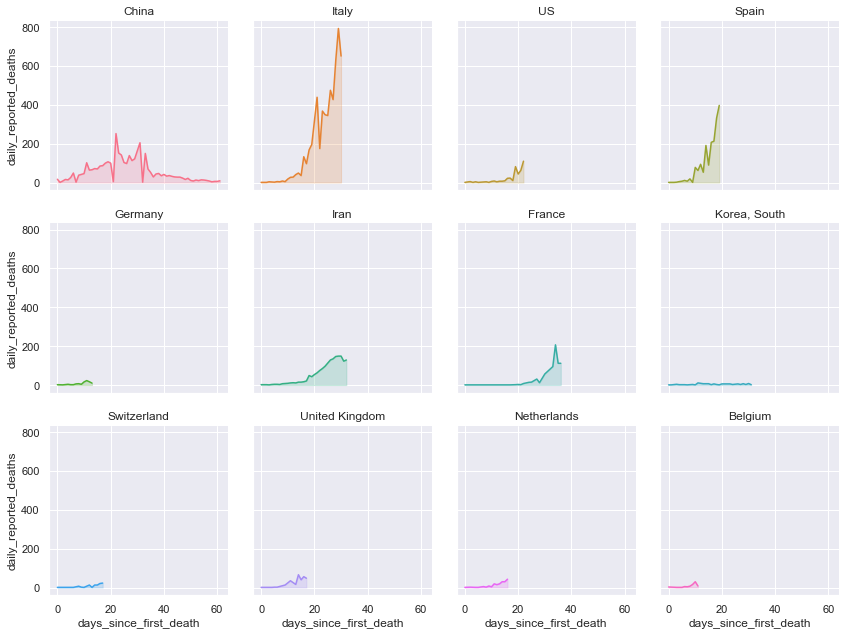

In [26]:
#sns.set(style="ticks")
with sns.axes_style("darkgrid"):
    grid = sns.FacetGrid(countries_df_deaths, col="Country", hue='Country', col_wrap=4, height=3)
    grid.map(plt.plot, "days_since_first_death", "daily_reported_deaths").set_titles("{col_name}")
    grid.map(plt.fill_between, "days_since_first_death", "daily_reported_deaths", alpha=0.2).set_titles("{col_name}")



## Recovered

In [27]:
df_recovered = pd.read_csv('time_series_19-covid-Recovered.txt')
df_recovered.drop(['Long', 'Lat'], axis=1, inplace=True)
df_list = list()
for c in set(df_recovered['Country/Region']):
    country = c
    totals = df_recovered[df_recovered['Country/Region'] == country].sum()
    daily_new_cases = totals[2:].diff()
    # Place back first row
    daily_new_cases[0] = totals[2]
    df_country = pd.DataFrame(daily_new_cases)
    df_country = df_country.rename(columns={0:'daily_new_cases'})
    df_country['country'] = country
    df_list.append(df_country)
df_all_recovered = pd.concat(df_list)
df_all_recovered = df_all_recovered.reset_index().rename(columns={'index':'date'})
df_all_recovered = df_all_recovered[df_all_recovered['daily_new_cases'] > 0]
df_all_recovered['date'] = pd.to_datetime(df_all_recovered['date'])
#df_all_deaths.to_csv('covid19_deaths_2020_03_19.csv', index=False)

In [28]:
groups_recovered =  df_all_recovered.groupby('country')
top10_df = df_all_recovered[df_all_recovered['country'].isin(top10)]
df_list = list()
for c in top10:
    first_case = top10_df[top10_df['country'] == c]['date'].min()
    days_since_first_case = top10_df[top10_df['country'] == c]['date'] - first_case
    country_df = pd.DataFrame()
    country_df['days_since_first_recovery'] = days_since_first_case
    country_df['daily_recovered'] =  np.int64(top10_df[top10_df['country'] == c]['daily_new_cases'])
    country_df['Country'] = c
    df_list.append(country_df)
    print('{}: {}'.format(c, country_df['daily_recovered'].sum()))

countries_df_recovered = pd.concat(df_list, ignore_index=True)
countries_df_recovered['days_since_first_recovery'] = countries_df_recovered['days_since_first_recovery'].dt.days


China: 72814
Italy: 7025
US: 195
Spain: 2575
Germany: 266
Iran: 7931
France: 2206
Korea, South: 2926
Switzerland: 131
United Kingdom: 67
Netherlands: 2
Belgium: 293


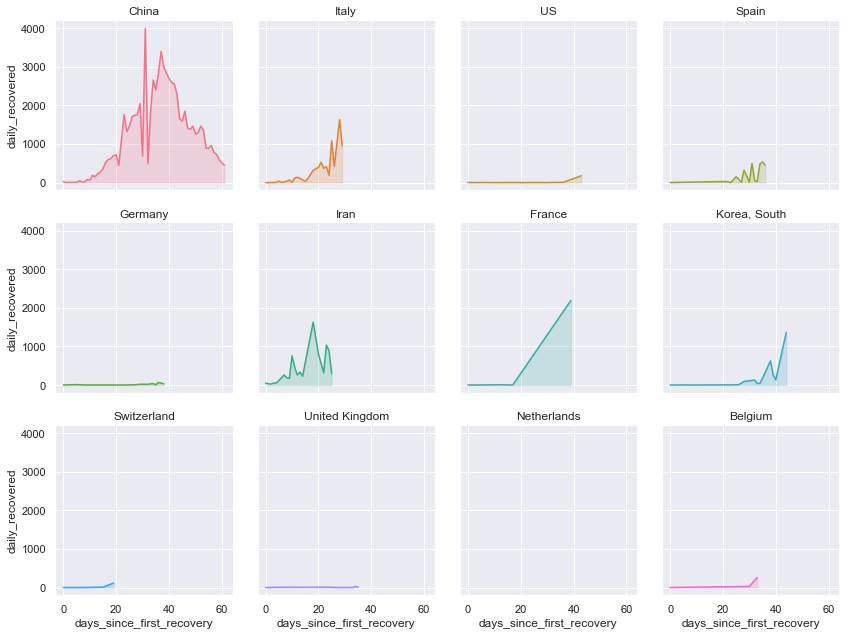

In [29]:
#sns.set(style="ticks")
with sns.axes_style("darkgrid"):
    grid = sns.FacetGrid(countries_df_recovered, col="Country", hue='Country', col_wrap=4, height=3)
    #grid.map(plt.plot, "days_since_first_recovery", "daily_recovered", marker="o", )
    grid.map(plt.plot, "days_since_first_recovery", "daily_recovered")
    grid.map(plt.fill_between, "days_since_first_recovery", "daily_recovered", alpha=0.2).set_titles("{col_name}")


